# LSTM-West-Texas-Price-Forecasting-ERCOT

The idea behind this project is to forecast energy price spikes in WEST_HUB (West Texas) settlement prices. By forecasting when energy price spikes occur in West Texas, we can enable battery companies to more efficiently perform energy arbitrage and optimize their charge/discharge timing.

### Value Proposition Of Project:

A battery storage system in West Texas can capture significant arbitrage opportunities by charging during low-price periods and discharging during high-price spikes. For example, a battery could charge at $25/MWh during off-peak hours and sell at $800/MWh during extreme price events. The ML project predicts West Texas settlement prices with a focus on identifying when price spikes will occur, enabling battery storage companies to optimize their operational timing and maximize revenue.

By forecasting this complex system where supply, demand, transmission constraints, and weather all influence prices, we can create profitable opportunities for energy storage deployment and operation.

### Scope:

I will focus exclusively on ERCOT's West Texas load zone (WEST_HUB), using historical settlement point price data to build an LSTM model that predicts hourly and daily price movements. The model will identify price spike opportunities by forecasting when West Texas prices will exceed certain thresholds (e.g., >$100/MWh), enabling battery storage companies to optimize their charge/discharge timing and maximize arbitrage profits in this specific geographic region.

### Predictors: 

Wind Generation captures the supply side volatility unique to West Texas - this is your most important differentiator from other forecasting models.
System Load captures the demand side fundamentals - this explains the baseline price patterns and peak events.
Natural Gas Prices captures the marginal cost structure - this sets the floor for how low prices can go and influences the merit order.

## 1. Importing and Cleaning Data:

In [6]:
import pandas as pd

final_ercot = pd.read_csv(r"C:\Users\mgray\OneDrive\Documents\Energy Forecasting\Data\ERCOT Data\final_ercot_merge.csv")
print(final_ercot.isna().sum())

missing_data_indicies = final_ercot[final_ercot.isna().any(axis=1)].index
print(missing_data_indicies)





Hour Ending                                                    0
SettlementPointPrice                                           0
DSTFlag                                                        0
WEST                                                           0
ERCOT                                                          0
ERCOT.WIND.GEN                                                 0
Wind Output, % of Load                                         0
Wind 1-hr MW change                                            2
Henry Hub Natural Gas Spot Price (Dollars per Million Btu)    22
dtype: int64
Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,    19,
          20,    21,  8033, 16064],
      dtype='int64')


## 2. Preliminary EDA:

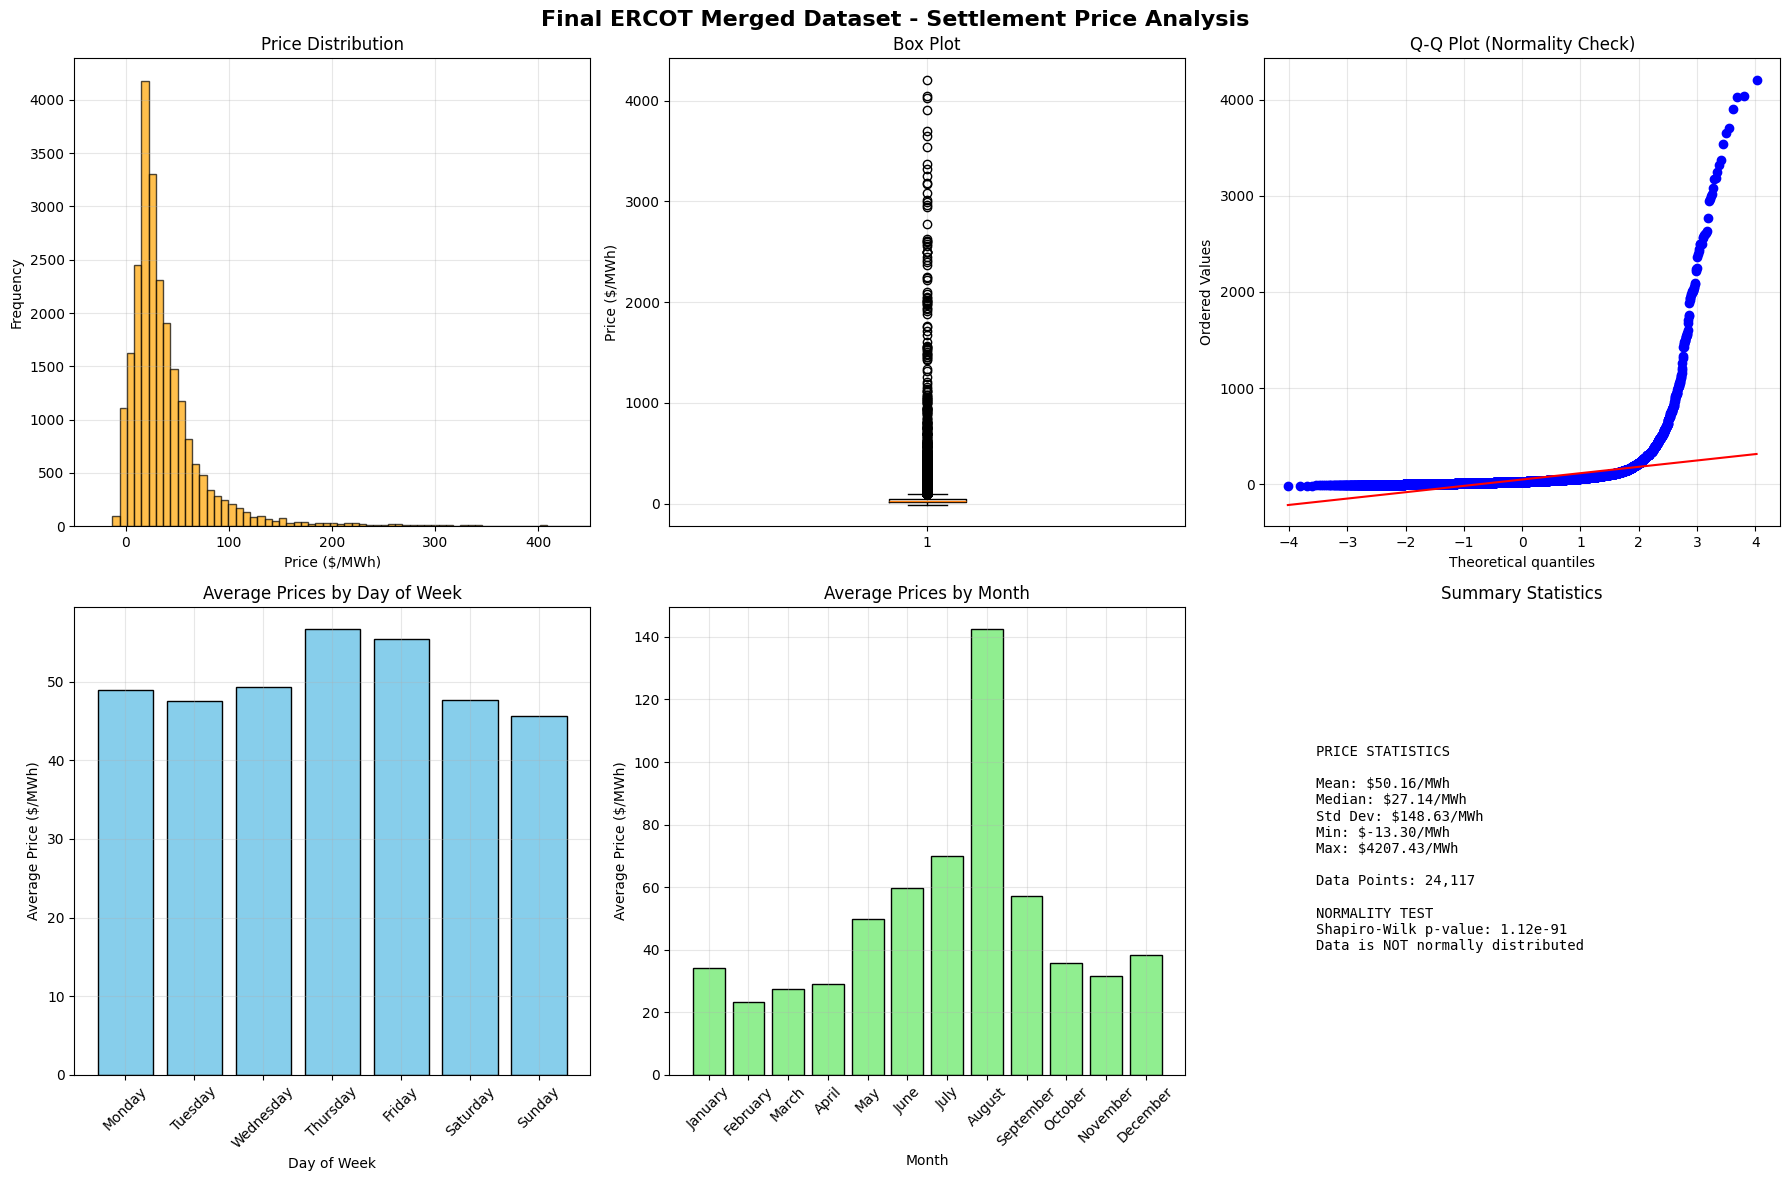

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

# Load your merged dataset
final_ercot = pd.read_csv(r"C:\Users\mgray\OneDrive\Documents\Energy Forecasting\Data\ERCOT Data\final_ercot_merge.csv")

# Convert Hour Ending to datetime if not already
final_ercot['Hour Ending'] = pd.to_datetime(final_ercot['Hour Ending'])
final_ercot['DeliveryDate'] = final_ercot['Hour Ending'].dt.date
final_ercot['DayOfWeek'] = final_ercot['Hour Ending'].dt.day_name()
final_ercot['Month'] = final_ercot['Hour Ending'].dt.month_name()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Final ERCOT Merged Dataset - Settlement Price Analysis', fontsize=16, fontweight='bold')

# 1. Histogram
axes[0, 0].hist(final_ercot['SettlementPointPrice'].dropna(), bins=600, alpha=0.7, color='orange', edgecolor='black')
axes[0, 0].set_xlabel('Price ($/MWh)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlim(-50, 450)
axes[0, 0].grid(True, alpha=0.3)

# 2. Box Plot
axes[0, 1].boxplot(final_ercot['SettlementPointPrice'].dropna())
axes[0, 1].set_ylabel('Price ($/MWh)')
axes[0, 1].set_title('Box Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot
stats.probplot(final_ercot['SettlementPointPrice'].dropna(), dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot (Normality Check)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Average prices by day of week
day_avg = final_ercot.groupby('DayOfWeek')['SettlementPointPrice'].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = day_avg.reindex(day_order)

axes[1, 0].bar(day_avg.index, day_avg.values, color='skyblue', edgecolor='black')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Average Price ($/MWh)')
axes[1, 0].set_title('Average Prices by Day of Week')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 5. Average prices by month
month_avg = final_ercot.groupby('Month')['SettlementPointPrice'].mean()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_avg = month_avg.reindex(month_order)

axes[1, 1].bar(month_avg.index, month_avg.values, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Price ($/MWh)')
axes[1, 1].set_title('Average Prices by Month')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# 6. Summary statistics as text
stats_text = f"""
PRICE STATISTICS

Mean: ${final_ercot['SettlementPointPrice'].mean():.2f}/MWh
Median: ${final_ercot['SettlementPointPrice'].median():.2f}/MWh
Std Dev: ${final_ercot['SettlementPointPrice'].std():.2f}/MWh
Min: ${final_ercot['SettlementPointPrice'].min():.2f}/MWh
Max: ${final_ercot['SettlementPointPrice'].max():.2f}/MWh

Data Points: {final_ercot['SettlementPointPrice'].count():,}
"""

# Normality test
try:
    shapiro_stat, shapiro_p = stats.shapiro(final_ercot['SettlementPointPrice'].dropna().sample(min(5000, final_ercot['SettlementPointPrice'].dropna().shape[0])))
    normality_text = f"\nNORMALITY TEST\nShapiro-Wilk p-value: {shapiro_p:.2e}\n"
    if shapiro_p < 0.05:
        normality_text += "Data is NOT normally distributed"
    else:
        normality_text += "Data appears normally distributed"
except Exception as e:
    normality_text = f"\nNORMALITY TEST\nCould not perform Shapiro-Wilk test: {e}"

axes[1, 2].text(0.1, 0.5, stats_text + normality_text, transform=axes[1, 2].transAxes, 
                fontsize=10, verticalalignment='center', fontfamily='monospace')
axes[1, 2].set_title('Summary Statistics')
axes[1, 2].axis('off')  

plt.tight_layout()
plt.show()

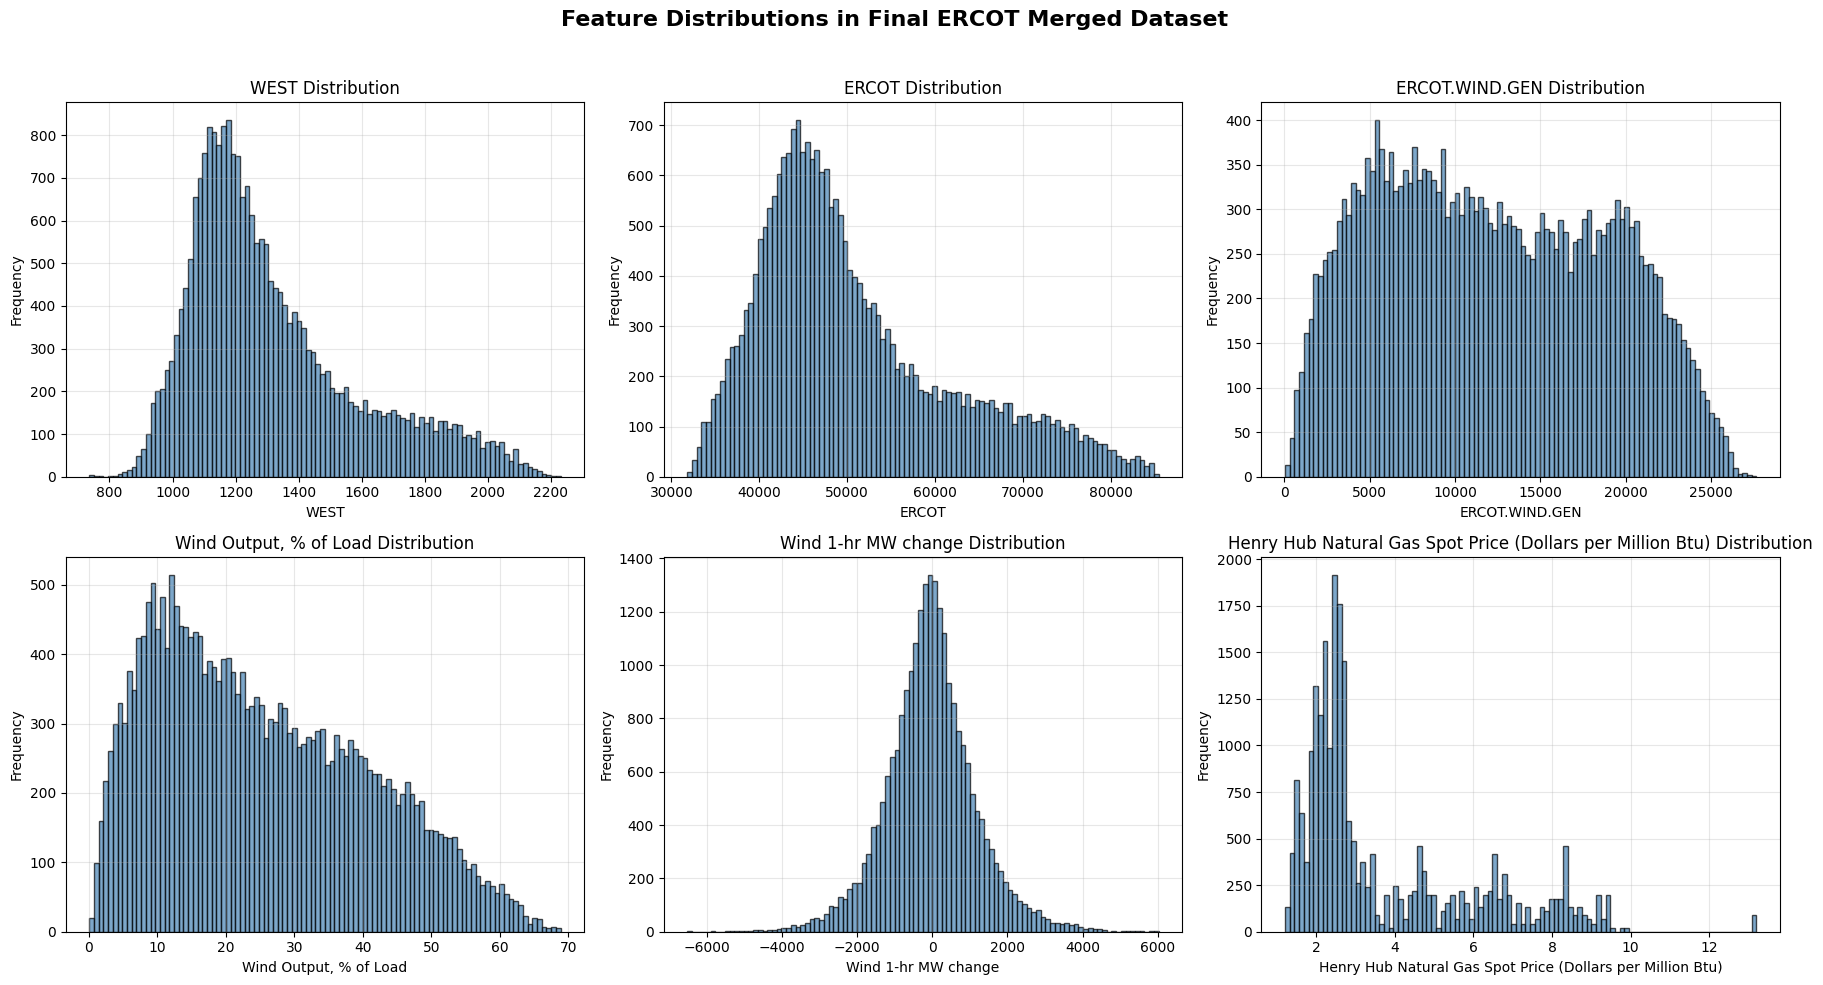

In [9]:
# List of feature columns to plot (excluding the target and datetime)
feature_cols = [
    'WEST',
    'ERCOT',
    'ERCOT.WIND.GEN',
    'Wind Output, % of Load',
    'Wind 1-hr MW change',
    'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Feature Distributions in Final ERCOT Merged Dataset', fontsize=16, fontweight='bold')

for i, col in enumerate(feature_cols):
    ax = axes[i // 3, i % 3]
    data = final_ercot[col].dropna()
    ax.hist(data, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

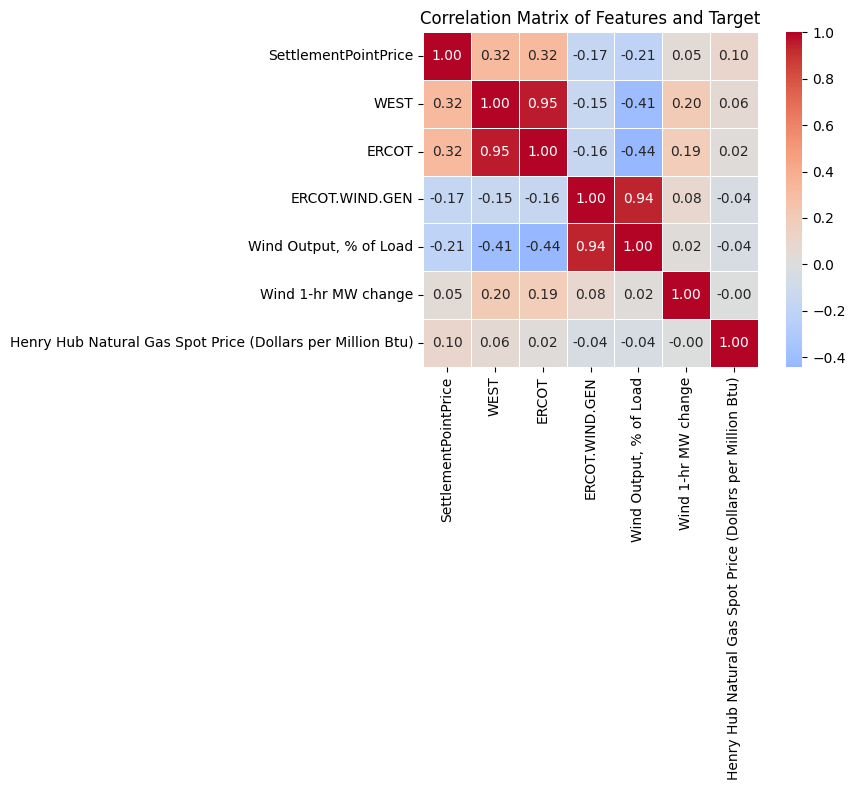

In [11]:

numeric_cols = [
    'SettlementPointPrice',
    'WEST',
    'ERCOT',
    'ERCOT.WIND.GEN',
    'Wind Output, % of Load',
    'Wind 1-hr MW change',
    'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)'
]

corr_matrix = final_ercot[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5, square=True)
plt.title('Correlation Matrix of Features and Target')
plt.tight_layout()
plt.show()

## 3. Basic Data Preparation For LSTM Model Prototyping

Starting LSTM model training for West Texas price forecasting...
Step 1: Preparing data...
Data shape: X=(26281, 24), y=(26281,)
Total sequences: 26281
Train set: 21024 samples
Test set: 5257 samples

Step 2: Building model...


c:\Users\mgray\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)


Step 3: Training model...
Epoch 1/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 4.2650e-04 - mean_absolute_error: 0.0091 - val_loss: 3.4378e-05 - val_mean_absolute_error: 0.0022
Epoch 2/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 1.9842e-04 - mean_absolute_error: 0.0058 - val_loss: 3.1087e-05 - val_mean_absolute_error: 0.0020
Epoch 3/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 1.8336e-04 - mean_absolute_error: 0.0054 - val_loss: 3.2489e-05 - val_mean_absolute_error: 0.0031
Epoch 4/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.8765e-04 - mean_absolute_error: 0.0056 - val_loss: 2.8144e-05 - val_mean_absolute_error: 0.0019
Epoch 5/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6718e-04 - mean_absolute_error: 0.0052 - val_loss: 2.9486e-05 - val_mean_absolute_error: 0.0023
Epoch 6/50
657/657 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.6863e-04 - mean_absolute_error: 0.0052 - val_loss: 2.8382e-05 - val_mean_absolute_error: 0.0019
Epoch 7/50
657/657

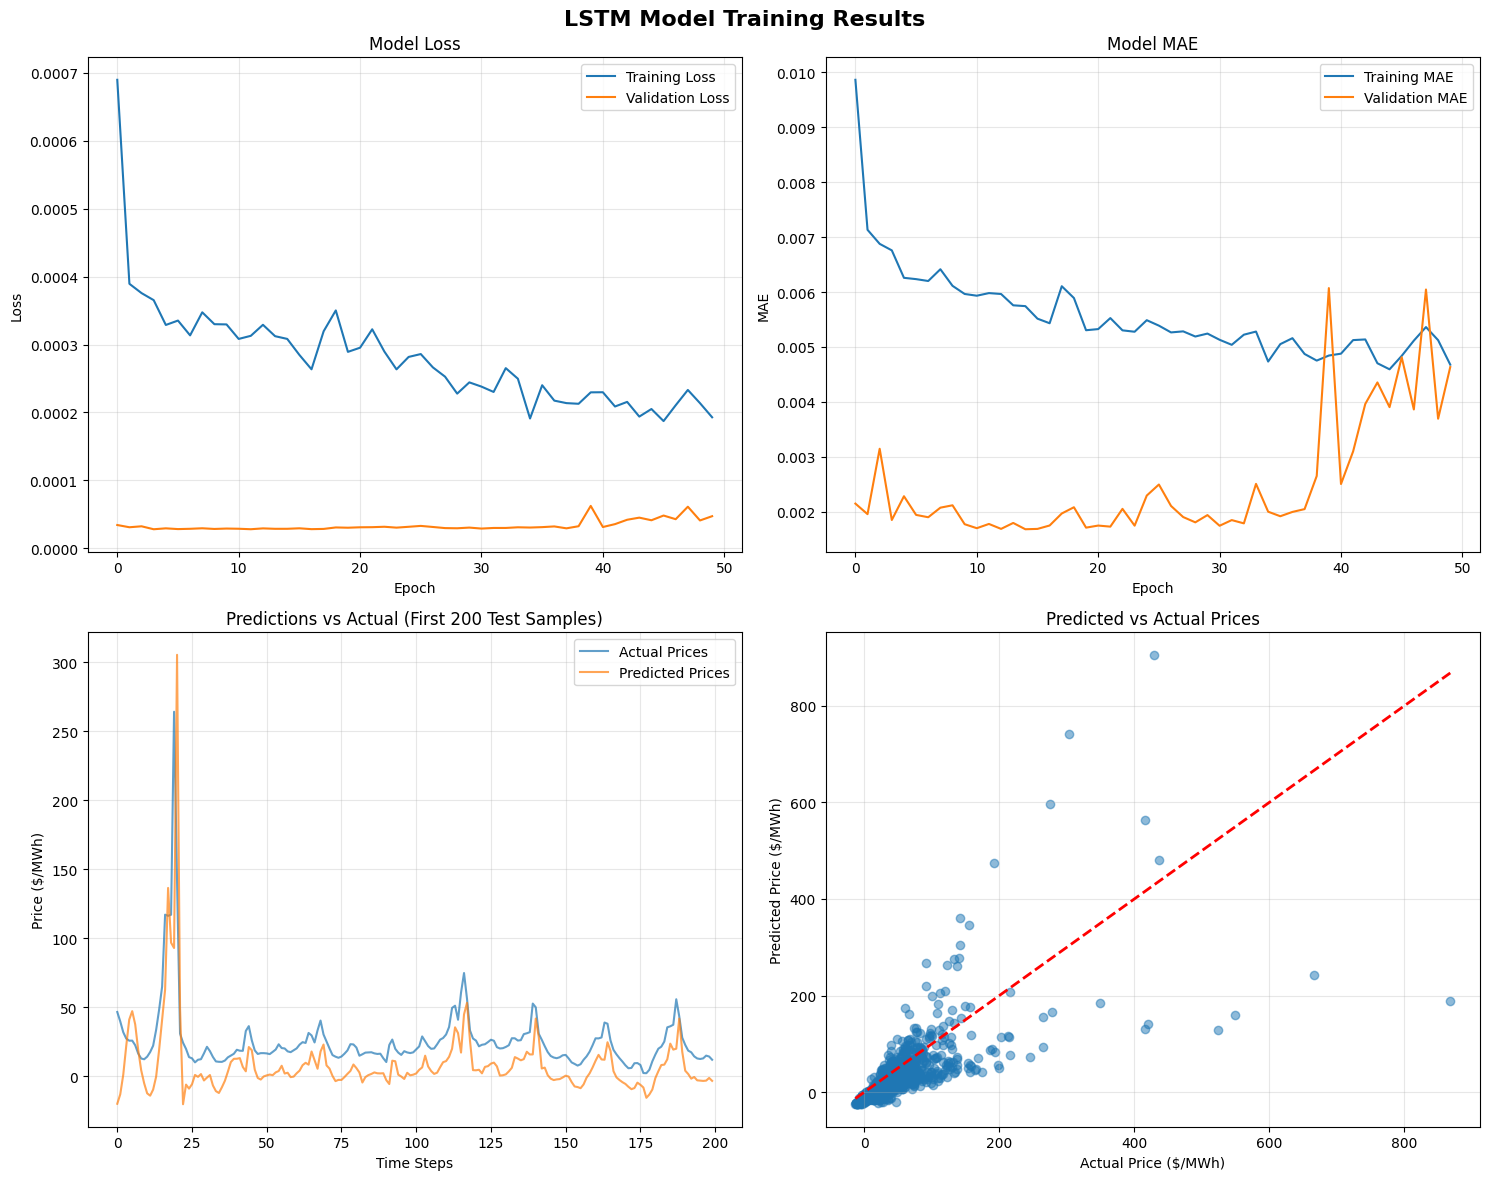

822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

Price Spike Analysis (Threshold: $100/MWh):
Total predictions: 26281
Predicted spikes: 1164 (4.4%)
Average predicted spike price: $336.63/MWh

Model training complete! Next steps:
1. Tune hyperparameters (sequence_length, LSTM units, epochs)
2. Add more features (weather, demand, wind generation)
3. Implement battery arbitrage strategy simulation
4. Optimize for specific price spike thresholds


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Prepare the data for LSTM
def prepare_lstm_data(data, sequence_length=24):
    """
    Convert time series data into sequences for LSTM training
    sequence_length: Number of previous hours to use for prediction (24 = 1 day)
    """
    # Sort data by delivery date and hour
    data = data.sort_values(['DeliveryDate', 'HourEnding']).reset_index(drop=True)
    
    # Extract prices
    prices = data['SettlementPointPrice'].values.reshape(-1, 1)
    
    # Scale the data to 0-1 range (LSTM works better with normalized data)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(prices)
    
    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(scaled_prices)):
        X.append(scaled_prices[i-sequence_length:i, 0])  # Previous 24 hours
        y.append(scaled_prices[i, 0])  # Next hour price
    
    return np.array(X), np.array(y), scaler

# Step 2: Build the LSTM model
def build_lstm_model(sequence_length=24):
    """
    Build a simple LSTM model for price prediction
    """
    model = Sequential([
        # First LSTM layer with 50 units
        LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
        Dropout(0.2),  # Prevent overfitting
        
        # Second LSTM layer
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        
        # Dense output layer
        Dense(25),
        Dense(1)  # Single output (next hour price)
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model

# Step 3: Train the model
def train_lstm_model(hourly_data, sequence_length=24, test_size=0.2, epochs=50):
    """
    Complete training pipeline for LSTM model
    """
    print("Step 1: Preparing data...")
    X, y, scaler = prepare_lstm_data(hourly_data, sequence_length)
    
    print(f"Data shape: X={X.shape}, y={y.shape}")
    print(f"Total sequences: {len(X)}")
    
    # Reshape X for LSTM (samples, time steps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False  # Don't shuffle time series data
    )
    
    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    print("\nStep 2: Building model...")
    model = build_lstm_model(sequence_length)
    model.summary()
    
    print("\nStep 3: Training model...")
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=epochs,
        validation_data=(X_test, y_test),
        verbose=1,
        shuffle=False
    )
    
    print("\nStep 4: Evaluating model...")
    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Inverse transform to get actual prices
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train_actual, train_predictions)
    test_mae = mean_absolute_error(y_test_actual, test_predictions)
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
    
    print(f"\nModel Performance:")
    print(f"Train MAE: ${train_mae:.2f}/MWh")
    print(f"Test MAE: ${test_mae:.2f}/MWh")
    print(f"Train RMSE: ${train_rmse:.2f}/MWh")
    print(f"Test RMSE: ${test_rmse:.2f}/MWh")
    
    return model, scaler, history, {
        'X_test': X_test,
        'y_test_actual': y_test_actual,
        'test_predictions': test_predictions,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    }

# Step 4: Visualize results
def plot_training_results(history, results):
    """
    Plot training history and prediction results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('LSTM Model Training Results', fontsize=16, fontweight='bold')
    
    # Training loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Training MAE
    axes[0, 1].plot(history.history['mean_absolute_error'], label='Training MAE')
    axes[0, 1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    axes[0, 1].set_title('Model MAE')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Predictions vs Actual (sample of test data)
    sample_size = min(200, len(results['y_test_actual']))
    axes[1, 0].plot(results['y_test_actual'][:sample_size], label='Actual Prices', alpha=0.7)
    axes[1, 0].plot(results['test_predictions'][:sample_size], label='Predicted Prices', alpha=0.7)
    axes[1, 0].set_title(f'Predictions vs Actual (First {sample_size} Test Samples)')
    axes[1, 0].set_xlabel('Time Steps')
    axes[1, 0].set_ylabel('Price ($/MWh)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Scatter plot: Predicted vs Actual
    axes[1, 1].scatter(results['y_test_actual'], results['test_predictions'], alpha=0.5)
    axes[1, 1].plot([results['y_test_actual'].min(), results['y_test_actual'].max()], 
                    [results['y_test_actual'].min(), results['y_test_actual'].max()], 
                    'r--', lw=2)
    axes[1, 1].set_title('Predicted vs Actual Prices')
    axes[1, 1].set_xlabel('Actual Price ($/MWh)')
    axes[1, 1].set_ylabel('Predicted Price ($/MWh)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Step 5: Predict price spikes
def identify_price_spikes(model, scaler, data, threshold=100, sequence_length=24):
    """
    Use the trained model to identify potential price spikes
    """
    # Prepare data for prediction
    X, _, _ = prepare_lstm_data(data, sequence_length)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Make predictions
    predictions_scaled = model.predict(X)
    predictions = scaler.inverse_transform(predictions_scaled)
    
    # Identify spike opportunities
    spike_indices = np.where(predictions.flatten() > threshold)[0]
    
    print(f"\nPrice Spike Analysis (Threshold: ${threshold}/MWh):")
    print(f"Total predictions: {len(predictions)}")
    print(f"Predicted spikes: {len(spike_indices)} ({len(spike_indices)/len(predictions)*100:.1f}%)")
    print(f"Average predicted spike price: ${predictions[spike_indices].mean():.2f}/MWh")
    
    return predictions, spike_indices

# Example usage:
if __name__ == "__main__":
    # Assuming you have your hourly_ercot_dam_settlement_data loaded
    print("Starting LSTM model training for West Texas price forecasting...")
    
    # Train the model
    model, scaler, history, results = train_lstm_model(
        hourly_ercot_dam_settlement_data,
        sequence_length=24,  # Use 24 hours (1 day) to predict next hour
        epochs=35
    )
    
    # Plot results
    plot_training_results(history, results)
    
    # Identify price spikes
    predictions, spike_indices = identify_price_spikes(
        model, scaler, hourly_ercot_dam_settlement_data, threshold=100
    )
    
    print("\nModel training complete! Next steps:")
    print("1. Tune hyperparameters (sequence_length, LSTM units, epochs)")
    print("2. Add more features (weather, demand, wind generation)")
    print("3. Implement battery arbitrage strategy simulation")
    print("4. Optimize for specific price spike thresholds")

## 4. Feature Engineering